# **Naive Bayes Spam Filter**
### CMSC 197 (Machine Learning), Machine Problem 3
*Submitted by: Sharah Michelle Tuando*

GitHub link: https://github.com/sharahmichelle/CMSC-197


In [2]:
##### Standard Libraries #####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import email
import os
import chardet

##### For Validation of the Model #####
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### **Preprocessing**

1. Importing needed files from GDrive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
dir_data = '/content/drive/My Drive/197 (ML)/trec06p-cs280/unzipped/data/'
dir_label = '/content/drive/My Drive/197 (ML)/trec06p-cs280/labels.txt'
dir_stop_words = '/content/drive/My Drive/197 (ML)/stop_words.txt'

Mounted at /content/drive


In [5]:
# Load stop words
def load_stop_words(file_path):
  with open(file_path, 'r') as f:
    stop_words = set(f.read().splitlines())
  return stop_words

stop_words = load_stop_words(dir_stop_words)
stop_words_df = pd.DataFrame({'stop_word': list(stop_words)})
stop_words_df

,stop_word
0,getting
1,gone
2,invention
3,successfully
4,us
...,...
666,ninety
667,just
668,tries
669,likely


2. Remove words from the document which may not contribute to the information we want to extract. These includes dropping the alphanumeric characters and punctuation marks. Also, remove stop words, more popularly known as meaningless words, from the email body since those words are not useful in classification as well as reduce the dimensionality of the dictionary.

In [ ]:
df_emails = pd.DataFrame(columns=['folder', 'file', 'message', 'classification'])

df_labels = pd.read_csv(dir_label, sep='\s+', header=None, names=['classification', 'folder_file'], engine='python')
# Convert 'ham' to 0 and any other classification to 1
df_labels['classification'] = df_labels['classification'].apply(lambda x: 0 if x == 'ham' else 1)

# To preprocess text by removing unwanted elements
def preprocess_text(text, stop_words):
    # Punctuation characters to be removed
    punctuations = '!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    # Remove using translate method
    text = text.translate(str.maketrans('', '', punctuations + '0123456789'))
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and trim
    # Remove stop words and return the processed text
    return ' '.join([word for word in text.split() if word not in stop_words])

# To extract messages from parsed emails
def get_messages(parsed_email, charset, email_path):
    # Check if the email is multipart
    if parsed_email.is_multipart():
        for part in parsed_email.walk():
            if part.get_content_type() == 'text/plain':
                payload = part.get_payload(decode=True)
                if payload is not None:
                    charset = part.get_content_charset() or charset or 'utf-8'
                    try:
                        return payload.decode(charset, errors='ignore').strip()
                    except LookupError:
                        try:
                            return payload.decode('latin-1', errors='ignore').strip()
                        except:
                            return ''
                else:
                    return ''
    # For non-multipart emails
    payload = parsed_email.get_payload(decode=True)
    if payload is not None:
        charset = parsed_email.get_content_charset() or charset or 'utf-8'
        try:
            return payload.decode(charset, errors='ignore').strip()
        except LookupError:
            try:
                return payload.decode('latin-1', errors='ignore').strip()
            except:  #
                return ''
    else:
        return ''

# To detect the character set of an email file
def get_email_charset(email_path):
    with open(email_path, 'rb') as f:
        rawdata = f.read()
    result = chardet.detect(rawdata)
    charset = result['encoding']
    return charset

# To process an individual email file
def process_email(email_path, stop_words):
    charset = get_email_charset(email_path)
    with open(email_path, 'rb') as e_mail:
        parsed_email = email.message_from_bytes(e_mail.read())

    # Extract the message content from the parsed email
    message = get_messages(parsed_email, charset, email_path)
    # Preprocess the extracted message to clean it up
    processed_message = preprocess_text(message, stop_words)
    return processed_message

# Store the processed email details
processed_emails = {}

stop_words = set(stop_words)

for _, row in df_labels.iterrows():
    folder, file = row['folder_file'].split('/')[-2:]
    classification = row['classification']

    # Construct the full email path
    email_path = os.path.join(dir_data, folder, file)

    # Process the email to extract and clean the message
    processed_message = process_email(email_path, stop_words)

    # Add the processed email details to the dictionary
    processed_emails[email_path] = {
        'folder': folder,
        'file': file,
        'message': processed_message,
        'classification': classification
    }

    # Concatenate the processed email details into the DataFrame
    df_emails = pd.concat([df_emails, pd.DataFrame([{
        'folder': folder,
        'file': file,
        'message': processed_message,
        'classification': classification
    }])], ignore_index=True)  # Reset index after concatenation

df_emails

In [ ]:
# Convert dataframe to csv file
df_emails.to_csv('/content/drive/My Drive/197 (ML)/trec06p-cs280/processed_messages.csv', index=False, escapechar='\\')

In [5]:
# Import the cleaned file from GDrive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
processed_message_path = '/content/drive/My Drive/197 (ML)/trec06p-cs280/processed_messages.csv'

Mounted at /content/drive


In [6]:
new_data = pd.read_csv(processed_message_path)
new_data

,folder,file,message,classification
0,0,0,mailing list queried weeks ago running set arc...,0
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
3,0,3,greetings verify subscription planfans list ch...,0
4,0,4,chauncey conferred luscious continued tonsillitis,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1
37819,126,19,suffering pain depression heartburn well help ...,1
37820,126,20,prosperous future increased money earning powe...,1


3. Split the dataset into three(3) groups: training set for ham, training set for spam, and the testing set.
Folders 0-70: Train Set
Folders 71-127: Test set

In [7]:
df_train = new_data[new_data['folder'] <= 70]
df_test = new_data[new_data['folder'] > 70]
df_train_ham = df_train[df_train['classification'] == 0]
df_train_spam = df_train[df_train['classification'] == 1]

print("Training Ham: ", len(df_train_ham))
print("Training Spam: ", len(df_train_spam))
print("Testing Set: ", len(df_test))

Training Ham:  7523
Training Spam:  13777
Testing Set:  16522


4. After doing these methods, extract a list of unique words from the training set along with its summed number of occurrences from the spam and ham set. To limit the cardinality of the dictionary, we can extract only the 10000 most common words (common means that these words have the highest frequencies/occurences in the dataset).

In [8]:
# Store all words from the messages
all_words = []

for message in df_train['message']:
    if isinstance(message, str):
        all_words.extend(message.split())
    else:
        all_words.extend(str(message).split())

# Count the frequency of each word in the all_words
word_counts = Counter(all_words)

# Get the 10,000 most common words and their frequencies
top_10000_words = word_counts.most_common(10000)

df_top_10000_words = pd.DataFrame(top_10000_words, columns=['Word', 'Frequency'])
df_top_10000_words

,Word,Frequency
0,will,11464
1,board,5214
2,price,4983
3,company,4866
4,email,4394
...,...,...
9995,midwives,22
9996,witch,22
9997,restart,22
9998,lea,22


### **Creating the feature matrices**

1. Create feature matrices for ham training set with a dimensionality of 10000

In [9]:
# (number of ham messages, 10000 words)
ham_feature_matrix = np.zeros((len(df_train_ham), 10000))

for i, message in enumerate(df_train_ham['message']):
    if isinstance(message, str):
        words = message.split()
        for word in words:
            try:
                # Find the index of the word in df_top_10000_words and set the corresponding position in ham_feature_matrix to 1
                word_index = df_top_10000_words[df_top_10000_words['Word'] == word].index[0]
                ham_feature_matrix[i, word_index] = 1
            except IndexError:
                pass

In [10]:
ham_feature_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

2. Create feature matrices for spam training set with a dimensionality of 10000

In [11]:
# (number of ham messages, 10000 words)
spam_feature_matrix = np.zeros((len(df_train_spam), 10000))
for i, message in enumerate(df_train_spam['message']):
    if isinstance(message, str):
        words = message.split()
        for word in words:
            try:
              # Find the index of the word in df_top_10000_words and set the corresponding position in spam_feature_matrix to 1
                word_index = df_top_10000_words[df_top_10000_words['Word'] == word].index[0]
                spam_feature_matrix[i, word_index] = 1
            except IndexError:
                pass

In [12]:
spam_feature_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### **Computing the Priors**

In [13]:
prior_ham = len(df_train_ham) / len(df_train)
prior_spam = len(df_train_spam) / len(df_train)

print("Prior probability of ham:", prior_ham)
print("Prior probability of spam:", prior_spam)

Prior probability of ham: 0.3531924882629108
Prior probability of spam: 0.6468075117370892


### **Computing the Likelihood of each word**

In [14]:
likelihood_ham = {}
likelihood_spam = {}

# Laplace smoothing value
a = 1
# Total unique words
V = 10000

# Calculate the count of each word in ham messages
wordcount_ham = np.sum(ham_feature_matrix, axis=0)
# Calculate the count of each word in spam messages
wordcount_spam = np.sum(spam_feature_matrix, axis=0)
top_10000_words_list = [key for key, _ in top_10000_words]

# Calculate likelihoods
for i, word in enumerate(top_10000_words):
    likelihood_ham[word] = (wordcount_ham[i] + a) / (np.sum(wordcount_ham) + a * V)
    likelihood_spam[word] = (wordcount_spam[i] + a) / (np.sum(wordcount_spam) + a * V)

In [15]:
likelihood_data = []

for i, word in enumerate(top_10000_words_list):
    likelihood_data.append({
        'Word': word,
        'Likelihood (Ham)': likelihood_ham[(word, word_counts[word])],
        'Likelihood (Spam)': likelihood_spam[(word, word_counts[word])]
    })

df_likelihood = pd.DataFrame(likelihood_data)
df_likelihood

,Word,Likelihood (Ham),Likelihood (Spam)
0,will,0.006274,0.004852
1,board,0.005512,0.001005
2,price,0.000362,0.003527
3,company,0.000428,0.003257
4,email,0.003951,0.001258
...,...,...,...
9995,midwives,0.000005,0.000002
9996,witch,0.000005,0.000002
9997,restart,0.000063,0.000002
9998,lea,0.000041,0.000002


### **Classifying the emails**

Based on the probabilities of words given the label computed, determine the
probability of ham and the probability of spam given the document. Whichever has a higher value will be the classification of the email. Baye’s rule was applied to the computed likelihoods.

In [16]:
def classify_email(email_message, prior_ham, prior_spam, likelihood_ham, likelihood_spam):
    # Calculate the log likelihood of ham
    log_likelihood_ham = np.log(prior_ham)
    # Calculate the log likelihood of spam
    log_likelihood_spam = np.log(prior_spam)


    if isinstance(email_message, str):
        words = email_message.split()
        for word in words:
            # Check if the word exists in the likelihood_ham dict
            if (word, word_counts[word]) in likelihood_ham:
                log_likelihood_ham += np.log(likelihood_ham[(word, word_counts[word])])

            # Check if the word exists in the likelihood_spam dict
            if (word, word_counts[word]) in likelihood_spam:
                log_likelihood_spam += np.log(likelihood_spam[(word, word_counts[word])])

    if log_likelihood_ham > log_likelihood_spam:
        # Return classification as 0 or ham along with the log likelihoods
        return 0, log_likelihood_ham, log_likelihood_spam
    else:
        # Return classification as 1 or spam along with the log likelihoods
        return 1, log_likelihood_ham, log_likelihood_spam

### **Testing the Classifier**

After you’re done with the Naïve Bayes Classifier, implement code for classifying an unknown message and try it on the test set.

In [17]:
# Store classification results
results = []

for _, row in df_test.iterrows():
    # Classify the email message and get the predicted label and log likelihoods
    predicted_label, log_ham, log_spam = classify_email(row['message'], prior_ham, prior_spam, likelihood_ham, likelihood_spam)
    results.append((row['classification'], predicted_label, log_ham, log_spam))

df_results = pd.DataFrame(results, columns=['True Label', 'Predicted Label', 'Log Likelihood Ham', 'Log Likelihood Spam'])

# Filter the results df
correctly_classified = df_results[df_results['True Label'] == df_results['Predicted Label']]
incorrectly_classified = df_results[df_results['True Label'] != df_results['Predicted Label']]

print(f"Correctly Classified Emails: {len(correctly_classified)}")
print(f"Incorrectly Classified Emails: {len(incorrectly_classified)}")

Correctly Classified Emails: 15370
Incorrectly Classified Emails: 1152


In [18]:
correctly_classified_percentage = (len(correctly_classified) / len(df_results)) * 100
incorrectly_classified_percentage = (len(incorrectly_classified) / len(df_results)) * 100

print(f"Percentage of Correctly Classified Emails: {correctly_classified_percentage:.2f}%")
print(f"Percentage of Incorrectly Classified Emails: {incorrectly_classified_percentage:.2f}%")

Percentage of Correctly Classified Emails: 93.03%
Percentage of Incorrectly Classified Emails: 6.97%


### **Performance Evaluation**

In [19]:
true_labels = df_results['True Label']
predicted_labels = df_results['Predicted Label']

# Calculate the accuracy, recall, and precision
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")

Accuracy: 93.03%
Recall: 91.47%
Precision: 98.06%


# **================================================================================**

# **Results and Discussion**

1. What is the effect of removing stop words in terms of precision, recall, and
accuracy? Show a plot or a table of these results.

           With Stop Words  Without Stop Words
Precision           0.9791              0.9806
Recall              0.8824              0.9147
Accuracy            0.9081              0.9303


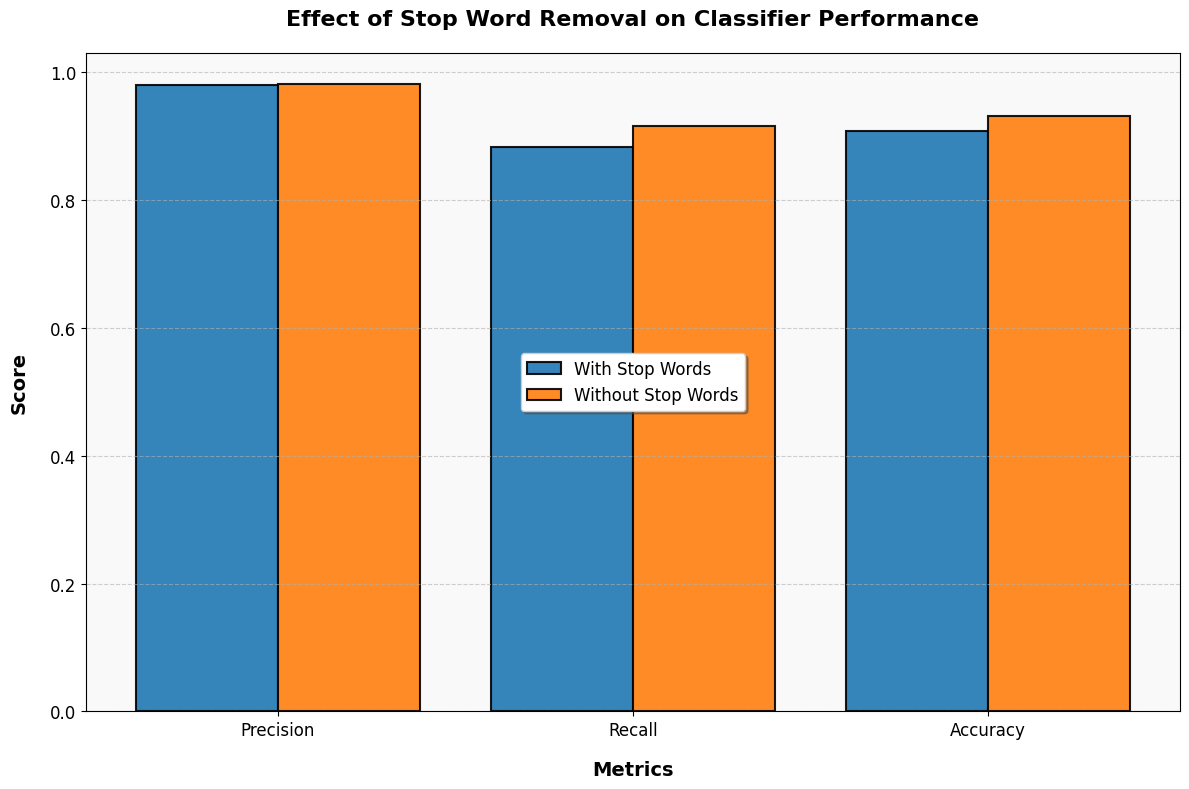

In [48]:
results = {
    # Full process for with stop words is found in the separate file
    'With Stop Words': {
        'Precision': 0.9791,
        'Recall': 0.8824,
        'Accuracy': 0.9081
    },
    # Values obtained above
    'Without Stop Words': {
        'Precision': 0.9806,
        'Recall': 0.9147,
        'Accuracy': 0.9303
    }
}

metrics = ['Precision', 'Recall', 'Accuracy']
data = [[results['With Stop Words'][metric], results['Without Stop Words'][metric]] for metric in metrics]
table = pd.DataFrame(data, index=metrics, columns=['With Stop Words', 'Without Stop Words'])
print(table)

# Plot to compare results
plt.figure(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(metrics))
colors = ['#1f77b4', '#ff7f0e']
opacity = 0.9
plt.bar(index, [results['With Stop Words'][metric] for metric in metrics], bar_width,
        label='With Stop Words', color=colors[0], alpha=opacity, edgecolor='black', linewidth=1.5)
plt.bar(index + bar_width, [results['Without Stop Words'][metric] for metric in metrics], bar_width,
        label='Without Stop Words', color=colors[1], alpha=opacity, edgecolor='black', linewidth=1.5)
plt.xlabel('Metrics', fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel('Score', fontsize=14, fontweight='bold', labelpad=15)
plt.title('Effect of Stop Word Removal on Classifier Performance', fontsize=16, fontweight='bold', pad=20)
plt.xticks(index + bar_width / 2, metrics, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='center', fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.gca().set_facecolor('#f9f9f9')
plt.tight_layout()
plt.show()

Since stop words consist of the most common words, it does not contribute to the meaning of the message so it is irrelevant for spam classification. It is best to remove them (based on the performance evaluation - higher accuracy, precision, and recall) to reduce the noise and dimensionality of the data and allow the classifier to focus only on relevant words.

2. Experiment on the number of words used for training. Filter the dictionary to
include only words occurring more than k times (1000 words, then k > 100, and k
= 50 times). For example, the word “offer” appears 150 times, that means that it
will be included in the dictionary.

In [33]:
k_values = [50, 100]
word_frequency = dict(top_10000_words)

# Iterate over each k
for k in k_values:
    filtered_words = {word: count for word, count in word_frequency.items() if count > k}
    filtered_word_list = list(filtered_words)
    print(f"Filtered Dictionary for k={k}: {len(filtered_words)} words")

Filtered Dictionary for k=50: 5006 words
Filtered Dictionary for k=100: 2849 words


As the value of k or frequency threshold increases, the size of the filtered dictionary decreases since the filtering becomes more selective or strict.

3. Discuss the results of the different parameters used for Lambda smoothing. Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate performance metrics for each.

   Lambda  Accuracy    Recall  Precision
0   2.000  0.930033  0.915222   0.979621
1   1.000  0.930275  0.914683   0.980553
2   0.500  0.930820  0.915312   0.980754
3   0.100  0.932030  0.916929   0.980976
4   0.005  0.930820  0.914953   0.981125


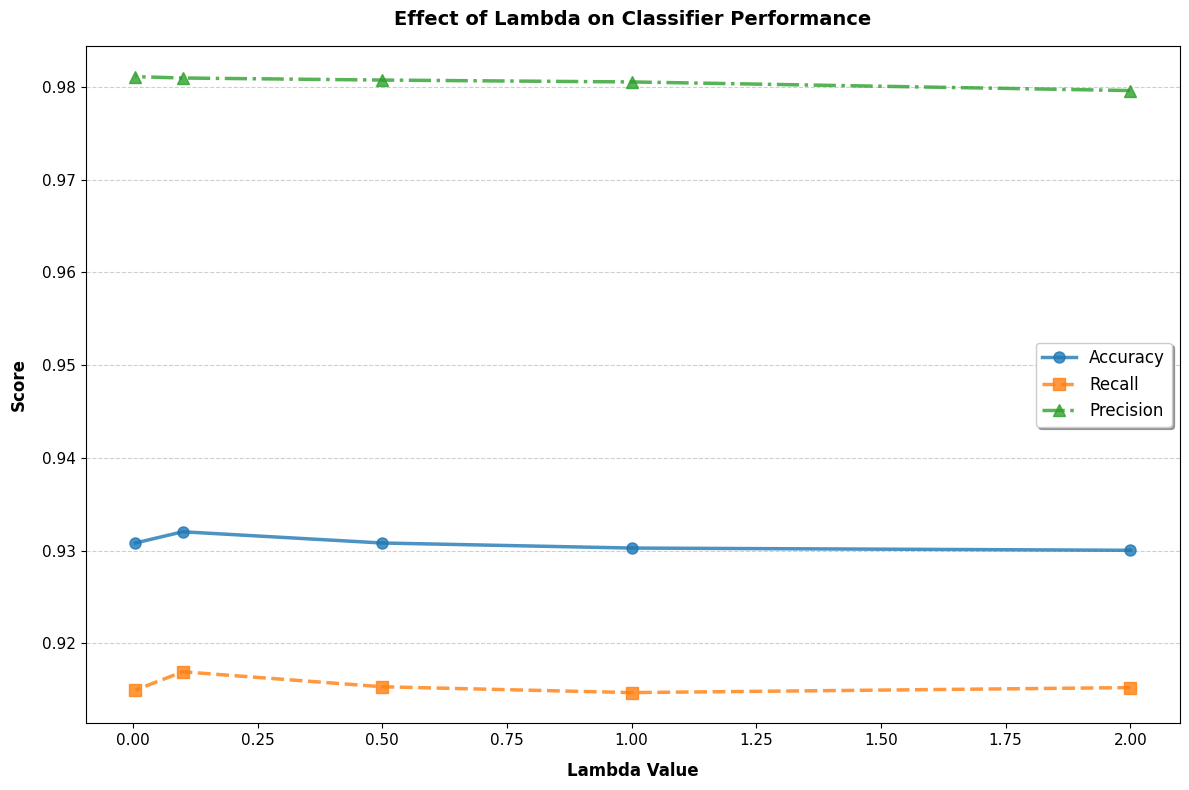

In [46]:
# Lambda values to test for smoothing in the likelihood calculations
lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]

# Store results for each lambda value
results_lambda = []

# Iterate over each lambda value
for lamda in lambda_values:
    # Store likelihoods for ham and spam classifications with the current lambda value
    likelihood_ham_lambda = {}
    likelihood_spam_lambda = {}
    V = 10000

    # Calculate the likelihood of each word given ham and spam using Laplace smoothing
    for i, word in enumerate(top_10000_words):
        likelihood_ham_lambda[word] = (wordcount_ham[i] + lamda) / (np.sum(wordcount_ham) + lamda * V)
        likelihood_spam_lambda[word] = (wordcount_spam[i] + lamda) / (np.sum(wordcount_spam) + lamda * V)

    # Store classification results for the current lambda
    results = []

    # Iterate over each row in the test to classify emails
    for _, row in df_test.iterrows():
        # Classify the email message
        predicted_label, log_ham, log_spam = classify_email(row['message'], prior_ham, prior_spam, likelihood_ham_lambda, likelihood_spam_lambda)
        results.append((row['classification'], predicted_label, log_ham, log_spam))

    df_results = pd.DataFrame(results, columns=['True Label', 'Predicted Label', 'Log Likelihood Ham', 'Log Likelihood Spam'])

    true_labels = df_results['True Label']
    predicted_labels = df_results['Predicted Label']

    # Calculate performance metrics (accuracy, recall, and precision)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)

    results_lambda.append({
        'Lambda': lamda,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision
    })

df_lambda_results = pd.DataFrame(results_lambda)
print(df_lambda_results)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(df_lambda_results['Lambda'], df_lambda_results['Accuracy'], label='Accuracy',
         color='#1f77b4', linewidth=2.5, linestyle='-', marker='o', markersize=8, alpha=0.8)
plt.plot(df_lambda_results['Lambda'], df_lambda_results['Recall'], label='Recall',
         color='#ff7f0e', linewidth=2.5, linestyle='--', marker='s', markersize=8, alpha=0.8)
plt.plot(df_lambda_results['Lambda'], df_lambda_results['Precision'], label='Precision',
         color='#2ca02c', linewidth=2.5, linestyle='-.', marker='^', markersize=8, alpha=0.8)
plt.xlabel('Lambda Value', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Score', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Effect of Lambda on Classifier Performance', fontsize=14, fontweight='bold', pad=15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='best', fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.tight_layout()
plt.show()

The smaller the lambda, the less the smoothing while larger lambda provides more smoothing. The lambda values that yields the best balance in performance metrics are values between 0 and 1. We can gain insights on the impact of different lambda values (based on the performance metrics) on the smoothing of Naive Bayes filter. Also, we can see that precision is the highest in the graph which means that our model can predic (or highly likely to be correct) if an email is a spam.

4. What are your recommendations to further improve the model?

- We can actually experiment with different lambda values to check the best value that can balance precision and recall.
- We can also use SVMs (Support Vector Machines) as another classification algorithm since it is known for its effectiveness in text classification and can handle high-dimensional feature spaces.
- Retrain the model from time to time by adding new data to evolve in detecting spam patterns.